In [6]:
import dill
dill.dump_session('.tmp/notebook_env.db')


In [ ]:
import dill
dill.load_session('.tmp/notebook_env.db')


In [2]:
# 导入需要的模块和函数
%load_ext autoreload
%autoreload 2


from utils.load import *
import pandas as pd


# 读取标记数据
# 从json文件读取标记数据，保存到df_labels中
df_labels = pd.read_json("/mnt/e/warehouse/education/master/scientific research/dataset/GTMarker/001/g2.json")

# 将时间戳格式化为 pandas中的日期时间类型
df_labels.datetime = pd.to_datetime(df_labels.datetime, format='%Y-%m-%d,%H:%M:%S')

# 新增两列空白的列
df_labels['pre1'] = ''
df_labels['pre2'] = ''


# 读取原始轨迹
# dataset_path = '/home/plw/dataset/Geolife Trajectories 1.3/Data/001/Trajectory/'
# dataset = enumerate(LoadG(dataset_path, 2))
# df_raws = pd.DataFrame()
# for i, df in dataset:
#     df['trackID'] = i + 1
#     df_raws = pd.concat([df_raws, df], ignore_index=True)
# df_raws.reset_index(drop=True)


In [11]:
from dpc.dpc_link_te import *
from dpc.dpc_link_te import DPCLink_TE as DPCLTE
from utils.inspection import *


for trackID, df_label in df_labels[df_labels.trackID==6].groupby('trackID'):

    # 一次提取
    dpc = DPCLTE(df_label)
    dpc.calDis()
    dpc.calDc(p=0.02)
    dpc.calRho()
    dpc.calDel()
    dpc.calGam()
    dpc.getCen(4)
    dpc.cluster(1)
    # 时序切割
    pieces = dpc.tempory()
    # 熵值约束
    df_prediciton1 = dpc.entropy(pieces, thresholdEI=1.5).copy(deep=True)
    df_labels.loc[df_prediciton1.index.tolist(), 'pre1'] = df_prediciton1.type

    # 二次提取
    for pie in pieces[:]:
        # 一次提取中切割后的子段
        tmp = dpc.df.loc[pie[0]:pie[1]]
        try:
            dpc2 = DPCLTE(tmp)
        except AssertionError:
            # 点数少于2
            continue
        dpc2.calDis()
        dpc2.calDc(p=0.2)
        dpc2.calRho()
        dpc2.calDel()
        dpc2.calGam()
        dpc2.getCen(1)
        dpc2.cluster(1)
        # 时序切割
        pieces2 = tempory(dpc2.df)
        # 熵值约束
        df_prediciton2 = dpc2.entropy(pieces2, thresholdEI=1.5, minPots=15)
        df_labels.loc[df_prediciton2.index.tolist(), 'pre2'] = df_prediciton2.type

    # if trackID == 1:
    #     break


eval = Evaluation(df_label, df_label)
try:
    df_prediciton1.set_index('rawIndex', drop=True, inplace=True)
except:
    pass
eval.setDfp(df_prediciton1)
print(f'accuracy:{eval.Acc():.2f}, precision:{eval.Precision():.2f}, recall:{eval.Recall():.2f}, findex:{eval.FI():.2f}')
try:
    df_prediciton2.set_index('rawIndex', drop=True, inplace=True)
except:
    pass
eval.setDfp(df_prediciton2)
print(f'accuracy:{eval.Acc():.2f}, precision:{eval.Precision():.2f}, recall:{eval.Recall():.2f}, findex:{eval.FI():.2f}')


accuracy:0.70, precision:0.58, recall:1.00, findex:0.74
accuracy:1.00, precision:-1.00, recall:-1.00, findex:-1.00


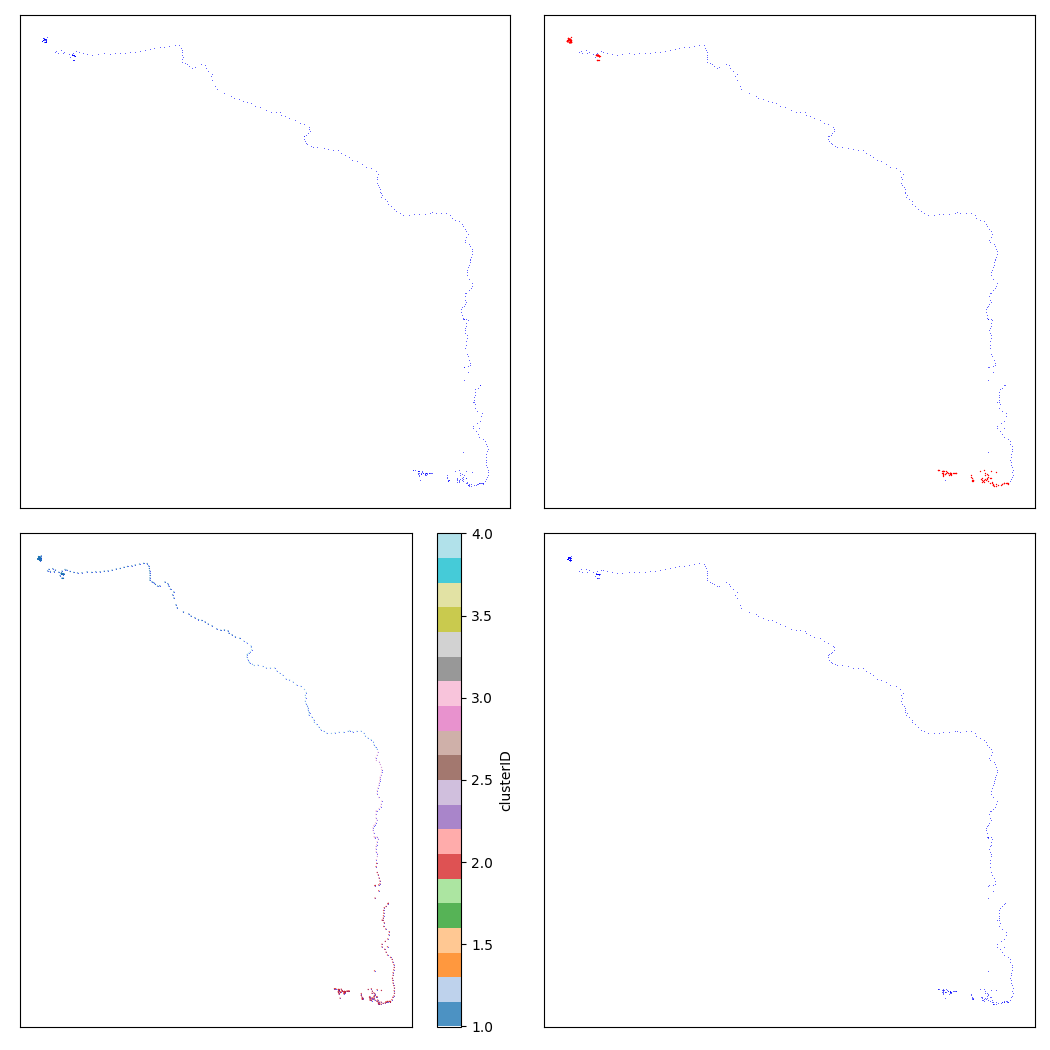

In [13]:
# 图表初始化
%matplotlib widget
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 2, figsize=(10.5, 10.5))
for (i, j), ax in np.ndenumerate(axes):
    df_label.plot.scatter(x='lng', y='lat', c='b', s=0.5, ax=ax, linewidths=0, alpha=0.5)  # 原始轨迹

# 一次提取的驻足点
# df_label[df_label.type == 'activity'].plot.scatter(x='lng', y='lat', c='r', s=1, ax=axes[0][0], linewidths=0)
df_label[df_label.pre1 == 'activity'].plot.scatter(x='lng', y='lat', c='g', s=20, ax=axes[0][0], linewidths=0)

# 二次提取的驻足点
df_label[df_label.type == 'activity'].plot.scatter(x='lng', y='lat', c='r', s=1, ax=axes[0][1], linewidths=0)
df_label[df_label.pre2 == 'activity'].plot.scatter(x='lng', y='lat', c='g', s=2, ax=axes[0][1], linewidths=0)

# 一次聚类分组结果
dpc.df.plot.scatter(x='lng', y='lat', c='clusterID', colormap='tab20', s=1, alpha=0.8, linewidths=0, ax=axes[1][0]) 

# 轨迹点信息显示
# for p in df_prediciton1.loc[:].itertuples():
#     # msg = f'{p.Index}\n{p.rho:.2f}\n{p.datetime}'
#     msg = f'{p.Index}\n{p.rho:.2f}'
#     axes[2].text(p.lng, p.lat, s=msg, fontsize=1)

# for i, p in enumerate(pieces):
#     dpc.df.loc[p[0]:p[1]].rawIndex.tolist()

# # 切片结果
# df_prediciton1[df_prediciton1.piecesID != -1].plot.scatter(x='lng', y='lat', c='piecesID', colormap='tab20', s=1, alpha=0.8, linewidths=0, ax=axes[2])
# # 一次提取的驻足点
# df_prediciton1[df_prediciton1.type == 'activity'].plot.scatter(x='lng', y='lat', c='r', s=0.5, ax=axes[0], linewidths=0)
# # 二次提取的驻足点
# df_prediciton2[df_prediciton2.type == 'activity'].plot.scatter(x='lng', y='lat', c='r', s=0.5, ax=axes[1], linewidths=0)
# # 聚类结果
# dpc.df.plot.scatter(x='lng', y='lat', c='clusterID', colormap='tab20', s=1, alpha=0.8, linewidths=0, ax=axes[3])
# 聚类中心点
# dpc.df.iloc[dpc.centers].plot.scatter(x='lng', y='lat', c='g', s=2, ax=ax, linewidths=0)

for (i, j), ax in np.ndenumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()


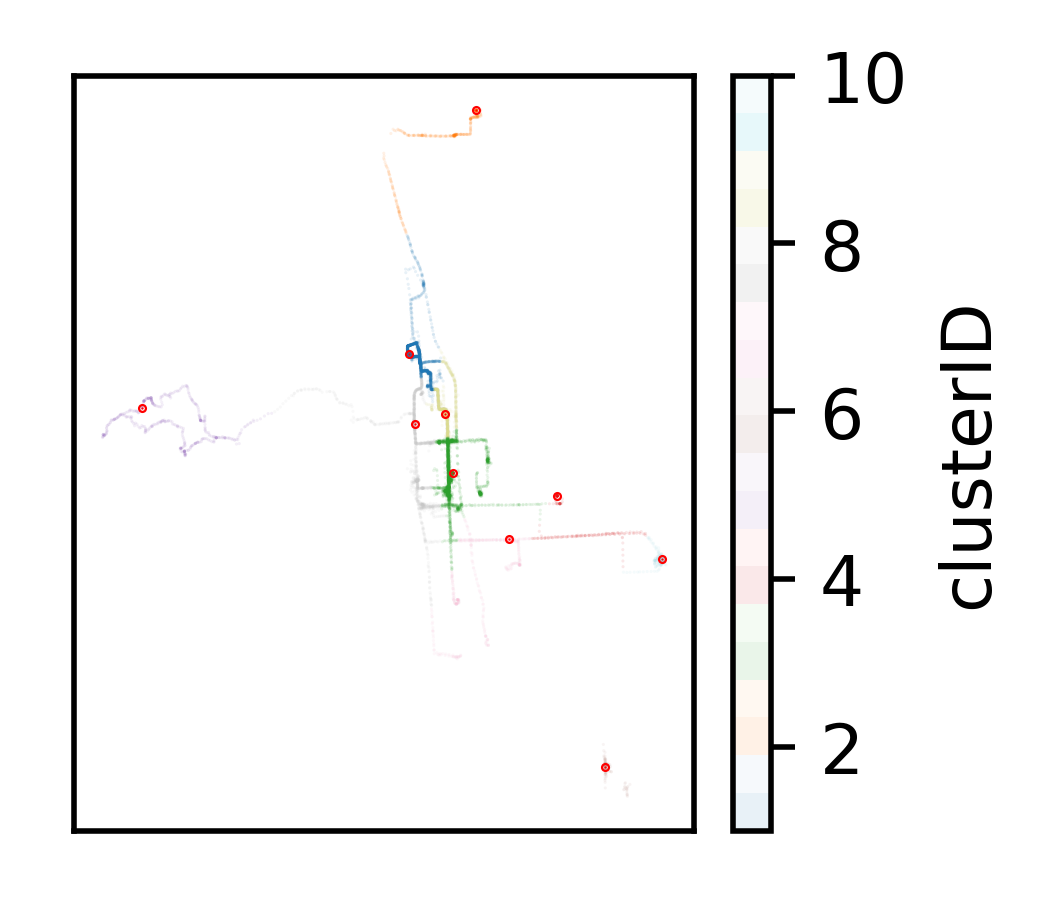

In [6]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=500)
dpc.df.plot.scatter(x='lng', y='lat', c='clusterID', colormap='tab20', s=0.2, alpha=0.1, linewidths=0, ax=ax)
# dfs.plot.scatter(x='lng', y='lat', s=0.1, alpha=0.1, linewidths=0, ax=ax)
dpc.df.iloc[dpc.centers].plot.scatter(x='lng', y='lat', c='red', s=0.1, ax=ax)
# p = dpc.df.iloc[6382]
# ax.scatter(p.lng, p.lat, c='red', s=0.1)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

m = folium.Map(location=[39.984094, 116.319236], zoom_start=16)
ls = []
dataset = enumerate(itertools.islice(LoadG(dataset_path), 0, 50))
for i, df in dataset:
    l = [[lat, lng]for [lat, lng, *_] in df.values]
    folium.PolyLine(l, weight=0.4).add_to(m)
    ls.extend(l)
HeatMap(ls).add_to(m)

for p in dpc.centers:
    folium.Marker([dpc.df.loc[p, 'lat'], dpc.df.loc[p, 'lng']]).add_to(m)
m.save('map/df.html')


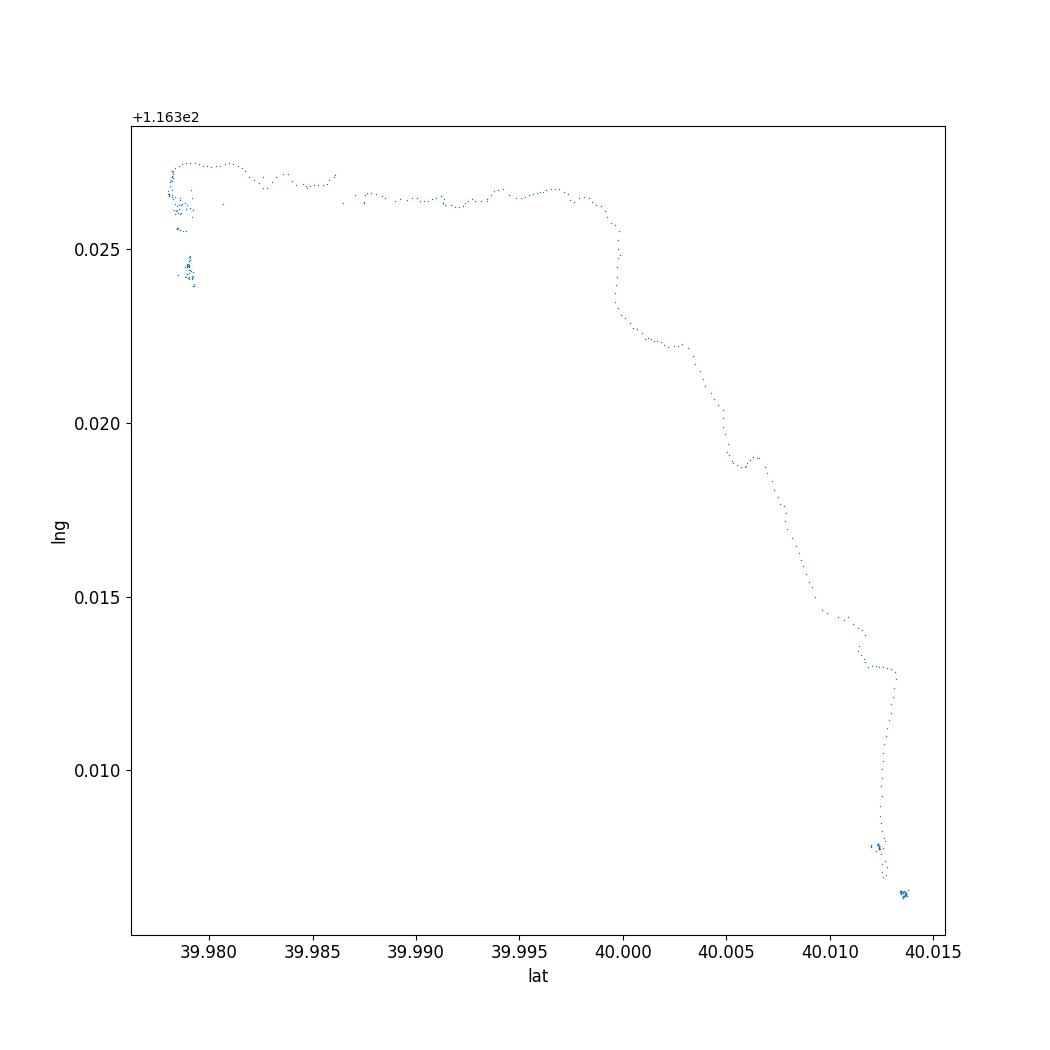

In [3]:
# 轨迹数据集可视化
%matplotlib widget

import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import folium


def track_matplot(df):
    fig, axis = plt.subplots(1, 1, figsize=(10.5, 10.5))
    df.plot.scatter(x='lat', y='lng', ax=axis, alpha=1, s=1, linewidth=0, fontsize=12)
    axis.set_xlabel('lat', fontsize=12)
    axis.set_ylabel('lng', fontsize=12)
    fig.savefig('figures/dataset.pdf', dpi=200, bbox_inches='tight')


def track_folium(df):
    locations = [[lat, lng] for [_, lat, lng, *_] in df.values]
    m = folium.Map(location=locations[0], zoom_start=12)
    HeatMap(locations).add_to(m)

    for _, df_track in df.groupby('trackID'):
        locations = [[lat, lng] for [_, lat, lng, *_] in df_track.values]
        folium.PolyLine(locations, weight=1, opacity=1).add_to(m)

    m.save('figures/df_test.html')


track_matplot(df_labels[df_labels.trackID == 6])
# track_folium(df_labels)


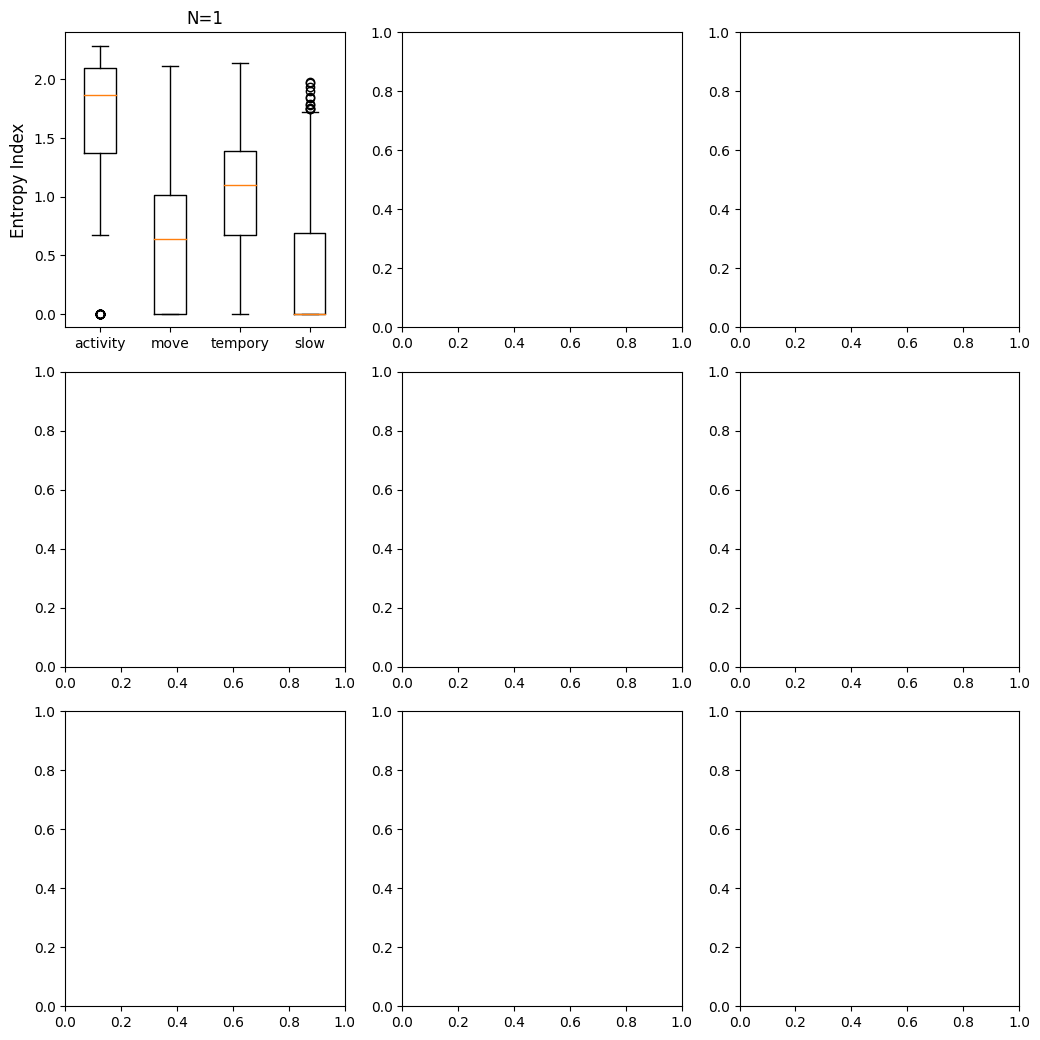

In [7]:
# ei分析
from utils.itertool import CutPieces2
from dpc.dpc_link_te import entropyIndex
from utils.itertool import Df2T
from matplotlib import pyplot as plt

num = 0
def EI(df_labels, N):
    global num
    statistics = {'activity': [], 'move': [], 'tempory': [], 'slow': []}
    for trackID, df_track in df_labels.groupby('trackID'):
        # if trackID not in g212:
        #     continue
        for pieces, p_type in CutPieces2(df_track, N):
            if not pieces:
                continue
            else:
                num += 1
            thetas = df_labels.loc[pieces]
            thetas = [t for t in Df2T(thetas)]
            ei = entropyIndex(thetas, 10)

            # 存在尚未标注数据none
            try:
                statistics[p_type].append(ei)
            except KeyError:
                continue
    return statistics


fig, axes = plt.subplots(3, 3, figsize=(10.5, 10.5))
for ax, N in zip(axes.ravel(), range(1, 2, 5)):
    statistics = EI(df_labels, N)
    ax.boxplot([statistics['activity'], statistics['move'], statistics['tempory'], statistics['slow']], labels=['activity', 'move', 'tempory', 'slow'])
    # ax.set_xlabel(fontsize=12)
    ax.set_ylabel('Entropy Index', fontsize=12)
    ax.set_title(f'N={N}', fontsize=12)

# statistics = EI(df_labels, 15)
# ax.boxplot([statistics['activity'], statistics['move'], statistics['tempory'], statistics['slow']], labels=['activity', 'move', 'tempory', 'slow'])

plt.tight_layout()
fig.savefig('figures/EI.pdf', dpi=200)


In [ ]:
# 距离矩阵检查
from dpc.dpc_link_te import DPCLink_TE
import matplotlib.pyplot as plt
%matplotlib widget


tmp = dpc.df.loc[8850:8862]
dpc_tmp = DPCLink_TE(tmp)
dpc_tmp.calDis()
df_tmp = dpc_tmp.df

fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

df_tmp.plot.scatter(x='lng', y='lat', s=10, alpha=1, linewidths=0, ax=ax)
for i, *_ in df_tmp[:df_tmp.shape[0] - 1].itertuples():
    for j, *_ in df_tmp[i + 1:df_tmp.shape[0]].itertuples():
        print(i, j)
        ax.arrow(df_tmp.loc[i, 'lng'],
                 df_tmp.loc[i, 'lat'],
                 df_tmp.loc[j, 'lng'] - df_tmp.loc[i, 'lng'],
                 df_tmp.loc[j, 'lat'] - df_tmp.loc[i, 'lat'],
                 width=0.0,
                 head_width=0.00,
                 alpha=0.1,
                 linestyle='-')
        ax.text(df_tmp.loc[j, 'lng'] + 0.00001, df_tmp.loc[j, 'lat'] + 0.00001, s=dpc_tmp.dis[0, j], fontsize=5)
    break

# 轨迹点信息显示
for p in df_tmp.itertuples():
    msg = f'{p.Index}'
    # msg = f'{p.rawIndex}'
    ax.text(p.lng, p.lat, s=msg, fontsize=5)


In [11]:
from utils.inspection import *
label, pre1, pre2 = convert(df_labels[df_labels.trackID <= 1])
eve = ConfusionMatrix2(pre1, label)
print(eve.accuracy())
eve = ConfusionMatrix2(pre2, label)
print(eve.accuracy())

0.58004158004158
0.35550935550935553
